# CS 9342 - Course Project
Dog and Cat Image Classification Using a Convolutional Neural Network

## I. Notebook Preparation

### A. Import libraries to use

In [1]:
import numpy as np
import pandas as pd 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

### B. Check dataset directory

In [2]:
import os
print(os.listdir("dogs-vs-cats"))

['sampleSubmission.csv', 'test1', 'train']


### C. Define the constants for image preprocessing

In [3]:
FAST_RUN = False
IMAGE_WIDTH=64 #image pixel width
IMAGE_HEIGHT=64 #image pixel height
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 #image RGB channel

### D. Prepare training data

In [4]:
filenames = os.listdir("dogs-vs-cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

### E. View prepared training data and total image count

In [5]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [6]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


<AxesSubplot:>

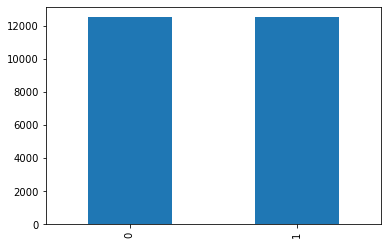

In [7]:
df['category'].value_counts().plot.bar()

### See sample image from dataset

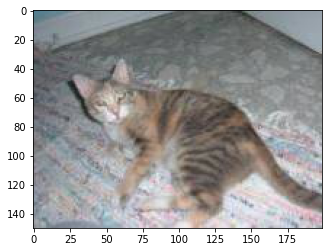

In [8]:
sample = random.choice(filenames)
image = load_img("dogs-vs-cats/train/"+sample)
plt.imshow(image)

## II. Building the convolutional neural network model

### A. Model architecture

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

### Show initial weights of the model

In [10]:
print(model.get_weights())

[array([[[[ 0.10072048, -0.06525451, -0.10189706,  0.01195563,
           0.07890698,  0.02817245, -0.09535146, -0.08998053,
          -0.08423257,  0.06300764,  0.12638716, -0.02874193,
          -0.01811878, -0.0445752 ,  0.11327346, -0.11457308,
          -0.11892354, -0.10087159,  0.02972983,  0.06938137,
           0.01731899,  0.08508895, -0.08902493, -0.00937937,
           0.05635959,  0.02460249,  0.09097238, -0.08988741,
          -0.04886685, -0.05538571, -0.07082603, -0.0702935 ],
         [ 0.1069732 ,  0.06530389,  0.11092962,  0.02325125,
           0.07242163,  0.09936135,  0.08294305, -0.01492872,
          -0.00202447, -0.12726808,  0.10355169, -0.01039933,
          -0.01203124,  0.1113724 , -0.03408558,  0.10365133,
           0.08770324, -0.09838101,  0.05126861,  0.12528105,
          -0.07373966, -0.06174879, -0.0559444 , -0.02163036,
          -0.126491  ,  0.03669146,  0.00521027, -0.06795807,
           0.12367277,  0.00416046, -0.08297504,  0.03936893],
     

### B. Set model callbacks (conditions for stopping)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#### Early Stopping
To prevent overfitting we will stop the training after 10 epochs when the val_loss value does not decrease.

In [12]:
earlystop = EarlyStopping(patience=10)

#### Learning Rate Reduction
We will reduce the learning rate when the accuracy does not increase for 2 epochs.

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

Set model callbacks

In [14]:
callbacks = [earlystop, learning_rate_reduction]

## III. Data preparation

### A. Set the classes

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

### B. Set the training parameters
- Train/Test Split: 80/20

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

### C. View training and validation data
- Training data: 20000 images
- Validation data: 5000 images

<AxesSubplot:>

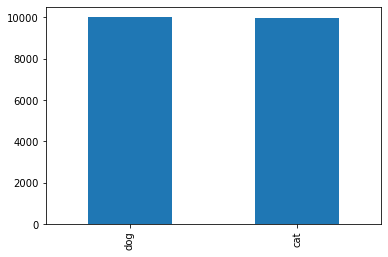

In [17]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

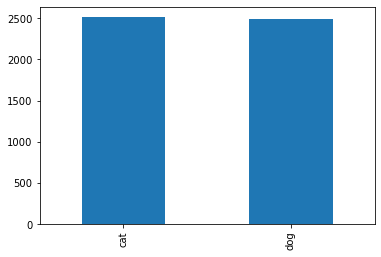

In [18]:
validate_df['category'].value_counts().plot.bar()

### D. Set batch size and model constants

In [19]:
batch_size=15
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

### E. Data augmentation
By applying transformations to the training data, we're adding synthetic data points. This exposes the model to additional variations without the cost of collecting and annotating more data. This can have the effect of reducing overfitting and improving the model's ability to generalize.

#### Training Dataset Augmentation

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


#### Validation Dataset Augmentation

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### F. Testing the data augmentation output

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "dogs-vs-cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


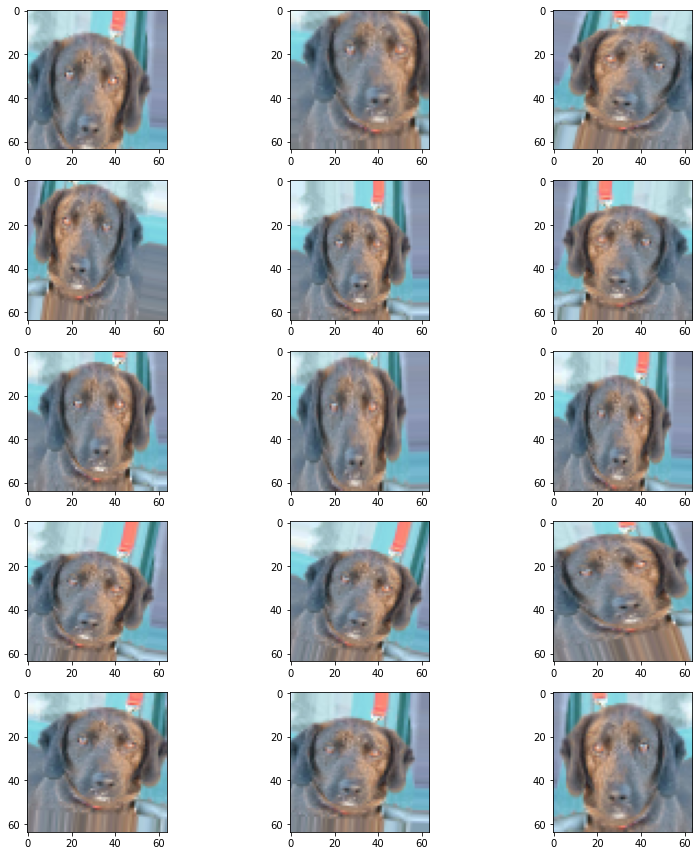

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### Viewing contents of an input image data

Pixels of the image: 12288
Number of dimensions: 3
Number of 1st dimension arrays: 64
[[[0.30212235 0.25803626 0.14822483]
  [0.38268968 0.2735344  0.11294179]
  [0.4261353  0.2708001  0.10121275]
  ...
  [0.54038316 0.35999098 0.15606941]
  [0.5353038  0.35491166 0.15099007]
  [0.53022444 0.3498323  0.14591071]]

 [[0.40662855 0.29098397 0.12177502]
  [0.44753888 0.30437177 0.11322001]
  [0.462144   0.30010587 0.12321823]
  ...
  [0.51084346 0.33045128 0.12860866]
  [0.5112667  0.33087456 0.1298785 ]
  [0.51169    0.33129784 0.13114834]]

 [[0.45304698 0.2933448  0.11704987]
  [0.4652275  0.30173033 0.12393916]
  [0.4490981  0.27498823 0.11088196]
  ...
  [0.5073744  0.32698226 0.1309038 ]
  [0.5035649  0.32317275 0.1270943 ]
  [0.49975538 0.3193632  0.12328477]]

 ...

 [[0.11286628 0.12070942 0.11678785]
  [0.12054598 0.12838912 0.12446755]
  [0.12006964 0.12791277 0.12399121]
  ...
  [0.8159504  0.68261707 0.49710327]
  [0.83919984 0.7319572  0.59590334]
  [0.8497486  0.75342715 0.

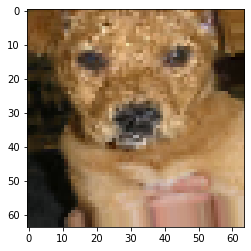

In [24]:
for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        print("Pixels of the image:", image.size)
        print("Number of dimensions:", image.ndim)
        print("Number of 1st dimension arrays:", len(image))
        print(image)
        break

## IV. Training the model

### A. Fitting the model with the preprocessed datasets and set parameters for training

In [25]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 118s 89ms/step - loss: 0.7488 - accuracy: 0.6180 - val_loss: 0.7644 - val_accuracy: 0.6066
Epoch 2/50
1333/1333 [==============================] - 118s 88ms/step - loss: 0.6217 - accuracy: 0.6630 - val_loss: 0.6673 - val_accuracy: 0.6270
Epoch 3/50
1333/1333 [==============================] - 117s 88ms/step - loss: 0.5970 - accuracy: 0.6853 - val_loss: 0.6068 - val_accuracy: 0.6755
Epoch 4/50
1333/1333 [==============================] - 117s 88ms/step - loss: 0.5653 - accuracy: 0.7104 - val_loss: 0.6231 - val_accuracy: 0.6701
Epoch 5/50
1333/1333 [==============================] - 118s 88ms/step - loss: 0.5429 - accuracy: 0.7248 - val_loss: 0.4794 - val_accuracy: 0.7662
Epoch 6/50
1333/1333 [==============================] - 118s 89ms/step - loss: 0.5192 - accuracy: 0.7416 - val_loss: 0.5463 - val_accuracy: 0.7249
Epoch 7/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.7524
Epoch 00007: ReduceL

### B. Saving the model weights

In [26]:
model.save_weights("model.h5")

### C. View results of training/fitting

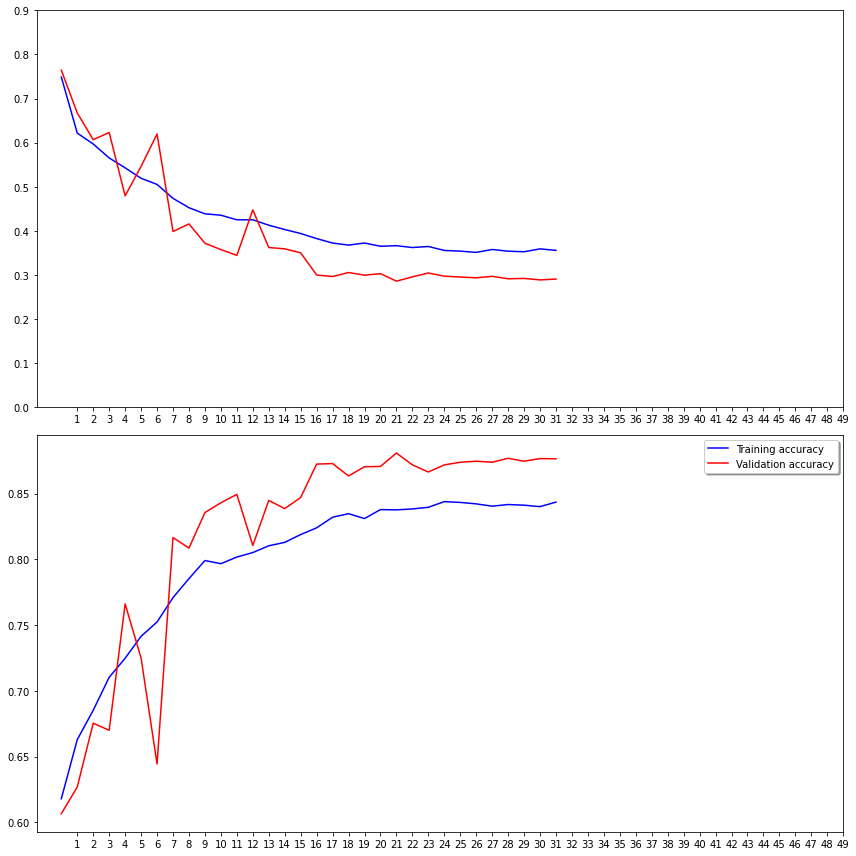

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## V. Testing the fitted model

### A. Preparing the testing data

In [28]:
test_filenames = os.listdir("dogs-vs-cats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### B. Setting the data augmentation for the testing data

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dogs-vs-cats/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## VI. Predict using the fitted model

### A. Prepare the augmented testing data for categorical classification

In [30]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [33]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### B. Visualize result

<AxesSubplot:>

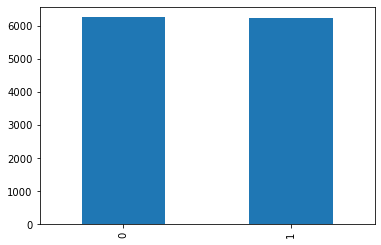

In [34]:
test_df['category'].value_counts().plot.bar()

### C. Test batch prediction of images using the trained model

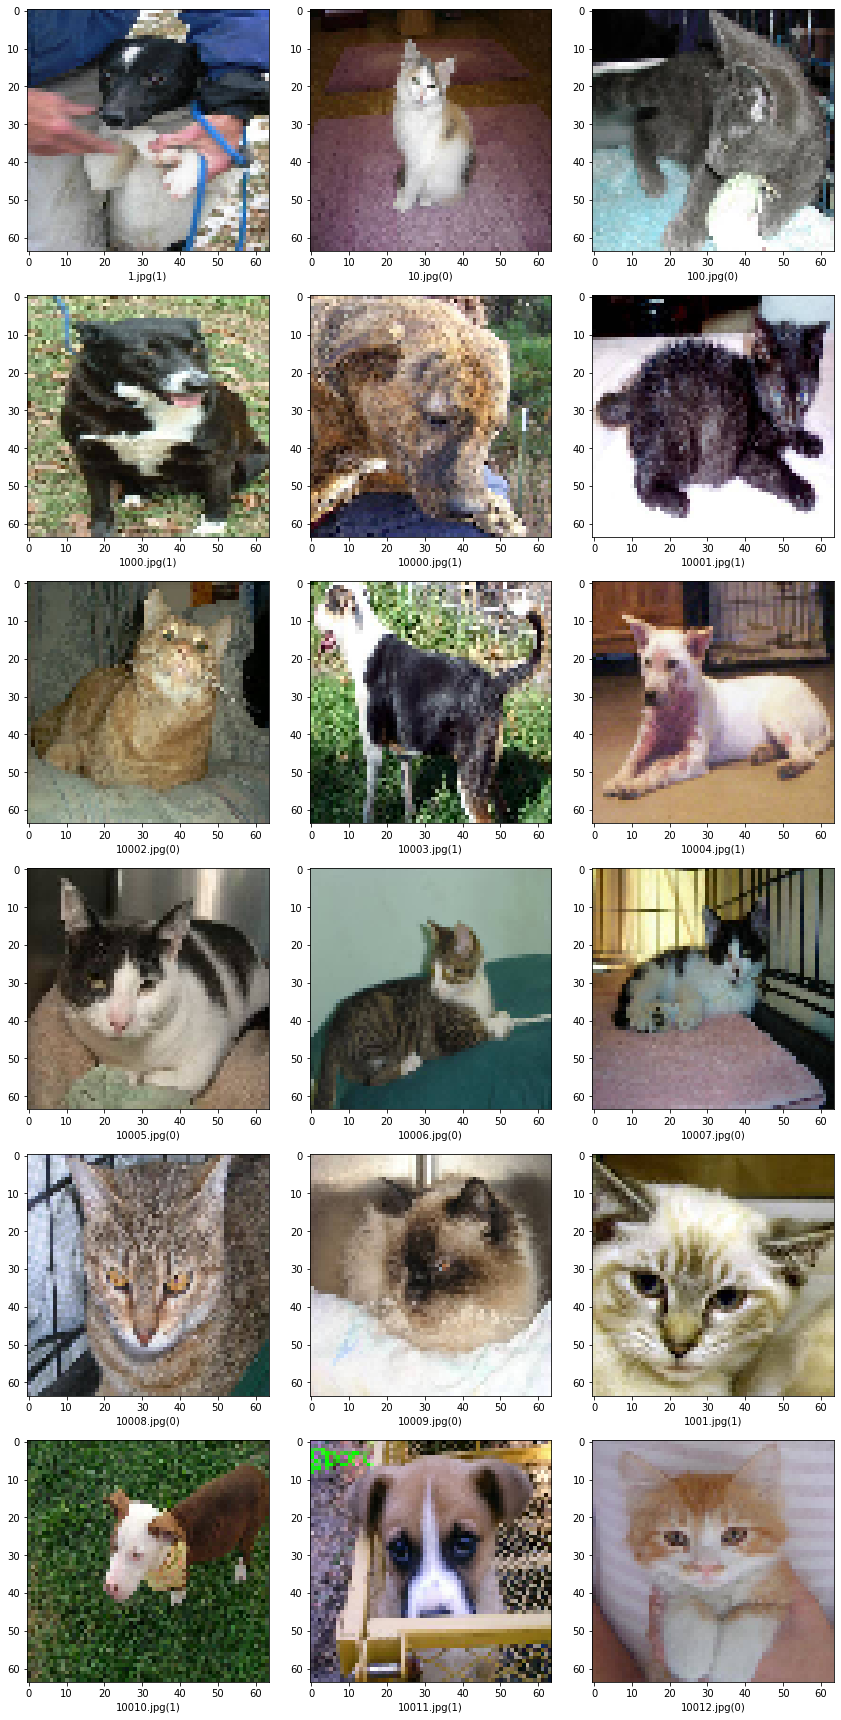

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("dogs-vs-cats/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

### D. Retrieve final weights/parameters of the model

In [36]:
print(model.get_weights())

[array([[[[ 1.81356966e-01, -1.59923688e-01, -2.30063260e-01,
           7.21082017e-02,  3.37396637e-02,  8.99123624e-02,
          -1.36282369e-01, -9.75576863e-02, -7.51110241e-02,
          -2.13401541e-02,  9.79196131e-02,  3.23640741e-02,
           1.24272248e-02, -1.07052788e-01,  4.28338945e-02,
          -1.66217059e-01, -1.53161868e-01, -3.79084535e-02,
          -1.44058332e-01,  6.92664310e-02, -2.80949026e-02,
          -1.74643602e-02, -1.28336623e-01, -4.78502251e-02,
           5.40765189e-02, -6.60020337e-02,  8.78246799e-02,
          -5.91489859e-02,  8.73579364e-03, -1.38241693e-01,
          -5.03811613e-02, -6.41564801e-02],
         [ 1.27483651e-01,  3.79908085e-02,  1.36967823e-01,
           1.48606703e-01,  4.36617061e-02,  2.58057654e-01,
           2.53689978e-02, -2.88000107e-02, -3.31262387e-02,
          -1.84072539e-01,  9.50975195e-02, -5.10059111e-03,
          -3.39189614e-03,  1.21526651e-01, -1.12009943e-01,
           2.23923065e-02,  3.90857086e

### E. Save final model/weights

In [37]:
model.save("weights")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: weights\assets


# End of notebook